<a href="https://colab.research.google.com/github/JoSungHun/Deeplearning/blob/master/classification_malware.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
from keras.callbacks import ModelCheckpoint
drive.mount('/content/gdrive')
vgg_callbackpath = '/content/gdrive/My Drive/DeepLearning_Project/2/vgg_callback/project_model.{epoch:02d}.hdf5'
resnet_callbackpath = '/content/gdrive/My Drive/DeepLearning_Project/2/resnet_callback/project_model.{epoch:02d}.hdf5'
resnet_callbackpath2 = '/content/gdrive/My Drive/DeepLearning_Project/2/resnet_callback/project_model2.{epoch:02d}.hdf5'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from keras import models
from keras import layers
from keras import optimizers
import os, shutil
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
import numpy as np
from keras import backend as K
from keras.applications.resnet50 import ResNet50, decode_predictions
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

> ### Prepare the dataset and data processing

* 데이터를 불러오고, train, validation, test로 데이터를 나눈다.
* imageDataGenerator를 사용하여 generator를 만든다.

In [0]:
dst_path = '/content/gdrive/My Drive/DeepLearning_Project/2/malware_image_dataset'

train_worm_dir = os.path.join(dst_path, 'train/worm')
train_others_dir = os.path.join(dst_path, 'train/others')

validation_worm_dir = os.path.join(dst_path, 'validation/worm')
validation_others_dir = os.path.join(dst_path, 'validation/others')

test_worm_dir = os.path.join(dst_path, 'test/worm')
test_others_dir = os.path.join(dst_path, 'test/others')

train_dir = os.path.join(dst_path, 'train')
val_dir = os.path.join(dst_path, 'validation')
test_dir = os.path.join(dst_path, 'test')

print('total training worm images:', len(os.listdir(train_worm_dir)))
print('total training others images:', len(os.listdir(train_others_dir)))

print('total validation worm images:', len(os.listdir(validation_worm_dir)))
print('total validation others images:', len(os.listdir(validation_others_dir)))

print('total test worm images:', len(os.listdir(test_worm_dir)))
print('total test others images:', len(os.listdir(test_others_dir)))

total training worm images: 4054
total training others images: 3286
total validation worm images: 500
total validation others images: 500
total test worm images: 500
total test others images: 500


In [0]:
datagen = image.ImageDataGenerator(rescale=1./255)

train_batches = datagen.flow_from_directory(train_dir,
                                      target_size=(64,64),
                                      class_mode='binary',
                                      shuffle=True,
                                      batch_size=20)

val_batches = datagen.flow_from_directory(val_dir,
                                      target_size=(64,64),
                                      class_mode='binary',
                                      shuffle=True,
                                      batch_size=20)

test_batches = datagen.flow_from_directory(test_dir,
                                      target_size=(64,64),
                                      class_mode='binary',
                                      shuffle=True,
                                      batch_size=20)

Found 7340 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


> ### Build the network (Using VGG16)
* vgg16 모델을 불러오고 그 위에 분류를 위한 레이어를 쌓는다

In [0]:
conv_base = VGG16(weights='imagenet', # imagenet으로 학습되어 있는 거를 가져옴.
                  include_top=False,  # colvoultional base만 가져옴 위에것 떼어오고
                  input_shape=(64, 64, 3)) # 우리것에 맞게 인풋을 조정

58892288/58889256 [==============================] - 3s 0us/step


In [0]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [0]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
conv_base.trainable = False
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 15,239,489
Trainable params: 524,801
Non-trainable params: 14,714,688
_________________________________________________________________


> ### Model Trainning
* vgg16 모델을 불러오고 그 위에 분류를 위한 레이어를 쌓는다

In [0]:
modelckpt = ModelCheckpoint(filepath=vgg_callbackpath)
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(train_batches,
                              steps_per_epoch=367,
                              epochs=10,
                              validation_data=val_batches,
                              validation_steps=50,
                              callbacks=[modelckpt])

Epoch 1/10
367/367 [==============================] - 593s 2s/step - loss: 0.1737 - acc: 0.9516 - val_loss: 0.1500 - val_acc: 0.9540
Epoch 2/10
367/367 [==============================] - 30s 81ms/step - loss: 0.1511 - acc: 0.9576 - val_loss: 0.1493 - val_acc: 0.9620
Epoch 3/10
367/367 [==============================] - 30s 81ms/step - loss: 0.1306 - acc: 0.9654 - val_loss: 0.1346 - val_acc: 0.9660
Epoch 4/10
367/367 [==============================] - 29s 80ms/step - loss: 0.1204 - acc: 0.9678 - val_loss: 0.1028 - val_acc: 0.9790
Epoch 5/10
367/367 [==============================] - 30s 81ms/step - loss: 0.1094 - acc: 0.9708 - val_loss: 0.1198 - val_acc: 0.9690
Epoch 6/10
367/367 [==============================] - 29s 79ms/step - loss: 0.1189 - acc: 0.9680 - val_loss: 0.1198 - val_acc: 0.9660
Epoch 7/10
367/367 [==============================] - 28s 78ms/step - loss: 0.1110 - acc: 0.9689 - val_loss: 0.1061 - val_acc: 0.9720
Epoch 8/10
367/367 [==============================] - 29s 80ms/

In [0]:
vgg_best_model = models.load_model(filepath='/content/gdrive/My Drive/DeepLearning_Project/2/vgg_callback/project_model.06.hdf5', compile=False)
vgg_model_predict = vgg_best_model.predict_generator(test_batches, steps=50,verbose=1)

50/50 [==============================] - 4s 89ms/step


In [0]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)}) #  출력을 이쁘게

In [0]:
 print(vgg_model_predict)

[[0.001]
 [0.971]
 [0.996]
 [0.996]
 [0.968]
 [0.977]
 [0.930]
 [0.091]
 [0.985]
 [0.984]
 [0.986]
 [0.980]
 [0.000]
 [0.003]
 [0.091]
 [0.092]
 [0.135]
 [0.033]
 [0.975]
 [0.998]
 [0.001]
 [0.979]
 [0.059]
 [0.029]
 [0.003]
 [0.981]
 [0.998]
 [0.000]
 [0.997]
 [0.304]
 [0.091]
 [0.988]
 [0.990]
 [0.091]
 [0.003]
 [0.995]
 [0.002]
 [0.947]
 [0.091]
 [0.091]
 [0.857]
 [0.091]
 [0.012]
 [0.379]
 [0.010]
 [0.995]
 [0.993]
 [0.000]
 [0.921]
 [0.998]
 [0.037]
 [0.000]
 [0.229]
 [0.621]
 [0.091]
 [0.960]
 [0.979]
 [0.997]
 [0.940]
 [0.996]
 [0.001]
 [0.000]
 [0.929]
 [0.968]
 [0.021]
 [0.091]
 [0.000]
 [0.980]
 [0.975]
 [0.001]
 [0.001]
 [0.005]
 [0.996]
 [0.001]
 [0.000]
 [0.824]
 [0.397]
 [0.983]
 [0.002]
 [0.001]
 [0.007]
 [0.103]
 [0.001]
 [0.999]
 [0.012]
 [0.091]
 [0.967]
 [0.091]
 [0.964]
 [0.998]
 [0.001]
 [0.003]
 [0.967]
 [0.016]
 [0.998]
 [0.091]
 [0.993]
 [0.962]
 [0.942]
 [0.998]
 [0.002]
 [0.158]
 [0.002]
 [0.008]
 [0.039]
 [0.103]
 [0.997]
 [0.924]
 [0.982]
 [0.999]
 [0.091]
 

> ### Modele Evaluate

* 가장 좋은 성능을 보인 모델을 사용하여 테스트 데이터 셋에 평가한다.

In [0]:
vgg_best_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
vgg_loss, vgg_acc = vgg_best_model.evaluate_generator(test_batches, steps = 50, verbose = 1)

50/50 [==============================] - 6s 118ms/step


In [0]:
print("vgg_loss :")
print(vgg_loss)
print()
print("vgg_acc : ")
print(acc)

vgg_loss :
0.11006668876856565

vgg_acc : 
0.9669999933242798


> ### Build the network (Using resnet)
* ResNet50을 사용하여 모델 설계

In [0]:
resnet = ResNet50(weights='imagenet',
                  include_top=False,  
                  input_shape=(64, 64, 3))
resnet.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
resnet_model = models.Sequential()
resnet_model.add(resnet)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(256, activation='relu'))
resnet_model.add(layers.Dense(1, activation='sigmoid'))
resnet.trainable = False
resnet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 25,685,377
Trainable params: 2,097,665
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
modelckpt = ModelCheckpoint(filepath=resnet_callbackpath)
resnet_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

history = resnet_model.fit_generator(train_batches,
                              steps_per_epoch=367,
                              epochs=10,
                              validation_data=val_batches,
                              validation_steps=50,
                              callbacks=[modelckpt])

Epoch 1/10
367/367 [==============================] - 1854s 5s/step - loss: 0.2427 - acc: 0.9248 - val_loss: 0.9758 - val_acc: 0.5000
Epoch 2/10
367/367 [==============================] - 35s 94ms/step - loss: 0.1669 - acc: 0.9469 - val_loss: 0.8726 - val_acc: 0.5090
Epoch 3/10
367/367 [==============================] - 34s 93ms/step - loss: 0.1299 - acc: 0.9575 - val_loss: 0.8203 - val_acc: 0.4850
Epoch 4/10
367/367 [==============================] - 34s 92ms/step - loss: 0.1229 - acc: 0.9590 - val_loss: 0.7820 - val_acc: 0.5210
Epoch 5/10
367/367 [==============================] - 34s 92ms/step - loss: 0.1096 - acc: 0.9606 - val_loss: 0.7441 - val_acc: 0.4960
Epoch 6/10
367/367 [==============================] - 34s 92ms/step - loss: 0.0968 - acc: 0.9654 - val_loss: 0.7709 - val_acc: 0.4910
Epoch 7/10
367/367 [==============================] - 34s 92ms/step - loss: 0.0946 - acc: 0.9681 - val_loss: 0.8458 - val_acc: 0.5000
Epoch 8/10
367/367 [==============================] - 34s 92ms

> ### resnet add Dropout
* 드롭아웃을 추가
* Dense 레이어 추가

In [0]:
resnet2_model = models.Sequential()
resnet2_model.add(resnet)
resnet2_model.add(layers.Flatten())
resnet2_model.add(layers.Dropout(0.5))
resnet2_model.add(layers.Dense(1024, activation='relu'))
resnet2_model.add(layers.Dense(512, activation='relu'))
resnet2_model.add(layers.Dense(256, activation='relu'))
resnet2_model.add(layers.Dense(1, activation='sigmoid'))
resnet.trainable = False
resnet2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              8389632   
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total para

In [0]:
modelckpt = ModelCheckpoint(filepath=resnet_callbackpath2)
resnet2_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

history = resnet2_model.fit_generator(train_batches,
                              steps_per_epoch=367,
                              epochs=10,
                              validation_data=val_batches,
                              validation_steps=50,
                              callbacks=[modelckpt])

Epoch 1/10
367/367 [==============================] - 55s 149ms/step - loss: 0.3197 - acc: 0.8888 - val_loss: 0.7194 - val_acc: 0.5000
Epoch 2/10
367/367 [==============================] - 47s 129ms/step - loss: 0.2334 - acc: 0.9253 - val_loss: 0.7129 - val_acc: 0.5000
Epoch 3/10
367/367 [==============================] - 48s 131ms/step - loss: 0.2073 - acc: 0.9339 - val_loss: 0.7319 - val_acc: 0.5000
Epoch 4/10
367/367 [==============================] - 47s 128ms/step - loss: 0.1908 - acc: 0.9379 - val_loss: 0.7368 - val_acc: 0.5000
Epoch 5/10
367/367 [==============================] - 45s 121ms/step - loss: 0.1852 - acc: 0.9413 - val_loss: 0.8121 - val_acc: 0.5000
Epoch 6/10
367/367 [==============================] - 43s 117ms/step - loss: 0.1821 - acc: 0.9437 - val_loss: 0.7573 - val_acc: 0.5000
Epoch 7/10
367/367 [==============================] - 44s 119ms/step - loss: 0.1920 - acc: 0.9477 - val_loss: 0.7714 - val_acc: 0.5000
Epoch 8/10
367/367 [==============================] - 4

In [0]:
resnet_loss, resnet_acc = resnet2_model.evaluate_generator(test_batches, steps = 50, verbose = 1)

50/50 [==============================] - 5s 108ms/step


In [0]:
print("resnet_loss :")
print(resnet_loss)
print()
print("resnet_acc : ")
print(resnet_acc)

resnet_loss :
0.7104809832572937

resnet_acc : 
0.4990000030398369


#클래스 활성화의 히트맵 시각화하기 (Grad-CAM)

True

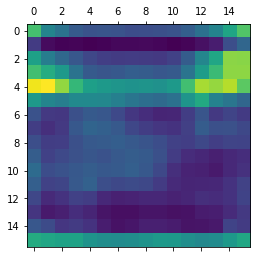

In [0]:
model = conv_base

img_path = '/content/gdrive/My Drive/DeepLearning_Project/2/malware_image_dataset/test/worm/worm (100).png'

img = image.load_img(img_path, target_size=(256,256))

x = image.img_to_array(img)

x = np.expand_dims(x,axis=0)

x = preprocess_input(x)

african_elephant_output = model.output[:,0]

last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0,1,2))

iterate = K.function([model.input],[pooled_grads,last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
  
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('/content/gdrive/My Drive/DeepLearning_Project/2/CAM.jpg', superimposed_img)

> ### Trouble Shooting
* 데이터셋은 grayscale 이미지 인데, vgg16 모델은 3차원 rgb 모델을 입력으로 받는다.
    * ImageDataGenerator에서 color_mode='grayscale' 이렇게 불러왔었는데, 그냥 디폴트로 하게 되면 grayscale을 rgb로 convert해서 불러온다
* load_model에서 /usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer. warnings.warn('Error in loading the saved optimizer  발생
  * load_model할때 인자로 compile=False 추가
* resnet모델 정확도가 너무 낮음.
  * Dropout 적용, 위에 층 추가 등 다양한 방법을 시도해 보았지만 해결하지 못하였음.

> ### Reference
* ppt 맨 뒷장에 표시